In [1]:
#General imports needed for path
import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import folium
import itertools

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Packages created by our group:
import route_dynamics.route_elevation.base_df as base
import route_dynamics.route_energy.knn as knn
from route_dynamics.route_riders import route_riders as ride
import route_dynamics.route_energy.longi_dynam_model as ldm
import route_dynamics.route_energy.accel as ca

In [4]:
#User defines what routes they want to evaluate
rt_list = [22,101,102,143,150,153,154,156,157,158,159,168,169,177,178,179,180,181,182,183,186,187,190,192]

route = rt_list[1]

time = 'XEV' #AM, MID, PM, XEV, XNT
#Import route shapefile

shapefile_name = '../data/rt' + str(route) + '_pts2.shp'

#Import bus stops shapefile

stops_shp = '../data/Transit_Stops_for_King_County_Metro__transitstop_point.shp'

signals_shp = '../data/traffic_signals2.shp'

trip183 = pd.read_csv("../data/Trip183.csv", usecols = ['SignRt', 'InOut', 'KeyTrip', 'BusType', 'Seats', 
                     'Period', 'AnnRides']) # KCM Data
trip183unsum = pd.read_csv("../data/Zon183Unsum.csv", usecols = ['Route', 'Dir', 'Trip_ID', 'InOut', 'STOP_SEQ', 'STOP_ID',
                     'Period', 'AveOn', 'AveOff', 'AveLd', 'Obs'])

#Acceleration profile
a_prof = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])

In [5]:
trip_df = ride.route_ridership(time, route, 14000)
geometry = trip_df.geometry.values

notes:   
22 - AM (1.46), **MID (3.14)**, PM (8.23), XEV (2.29)  
101 - AM (23.6), MID (19.6), PM (24.4), XEV (14.3), **XNT(21.1)**  
102 - AM (19.6), MID (), **PM (15.4)**, XEV (0.56), XNT(9.3)  
143 - **AM (11.4)**, MID (), PM (16.4), XEV (1.74), XNT()  
150 - AM (14.2), **MID (18.1)**, PM (22.57), XEV (23.5), XNT(15.4)

In [6]:
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i][0])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

stop_coords = xy_df.coordinates.values

In [7]:
signals = gpd.read_file(signals_shp)
signals = signals[signals['Route_Num']==str(route)]
geometry = signals.geometry.values
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

signal_coords = xy_df.coordinates.values

In [8]:
len(signal_coords)

38

In [9]:
mass_array = trip_df.Total_Mass.values

In [10]:
ex = ldm.RouteTrajectory(
route,
shapefile_name,
a_prof,
stop_coords,
signal_coords,
mass_array = mass_array,
unloaded_bus_mass = 14000,
charging_power_max = 160000
)

In [11]:
rt_df = ex.route_df

In [12]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,acceleration,velocity,delta_times,total_time,mass,grav_force,roll_fric,aero_drag,inertia,power_output
0,POINT (-122.33460 47.60971),0.0000,43.667205,11.175682,0.000000,False,False,False,0.000000,0.000000,0.000000,0.000000,14000.0,-0.000000,-1373.400000,-0.000000,0.000000,0.000000
1,POINT (-122.33473 47.60966),10.9728,43.681480,11.175682,0.001301,False,False,False,1.264274,3.186607,6.886949,6.886949,14000.0,-178.672734,-1373.398838,-5.693782,17699.836163,61366.412055
2,POINT (-122.33487 47.60960),21.9456,43.630557,11.175682,-0.004641,False,False,False,1.226868,4.815798,2.742425,9.629374,14000.0,637.372778,-1373.385210,-8.604796,17176.145379,86302.772022
3,POINT (-122.33500 47.60954),32.9184,43.517851,11.175682,-0.010271,False,False,False,1.211556,5.766712,2.073799,11.703173,14000.0,1410.600872,-1373.327558,-10.303875,16961.784873,97658.207292
4,POINT (-122.33514 47.60949),43.8912,43.346778,11.175682,-0.015591,False,False,False,1.092837,7.085541,1.707560,13.410734,14000.0,2140.953850,-1373.233116,-12.660339,15299.720907,103056.794651


In [13]:
rt_df['speed_limit'].mean()*2.23694

40.068834074076456

In [14]:
rt_df['speed_limit'].min()*2.23694

9.999731783638802

In [15]:
rt_df['speed_limit'].max()*2.23694

54.99852481001341

In [16]:
rt_df['total_time'].iloc[-1]/60

72.5723255182827

Text(0.5, 1, 'Load Profile for Route 101')

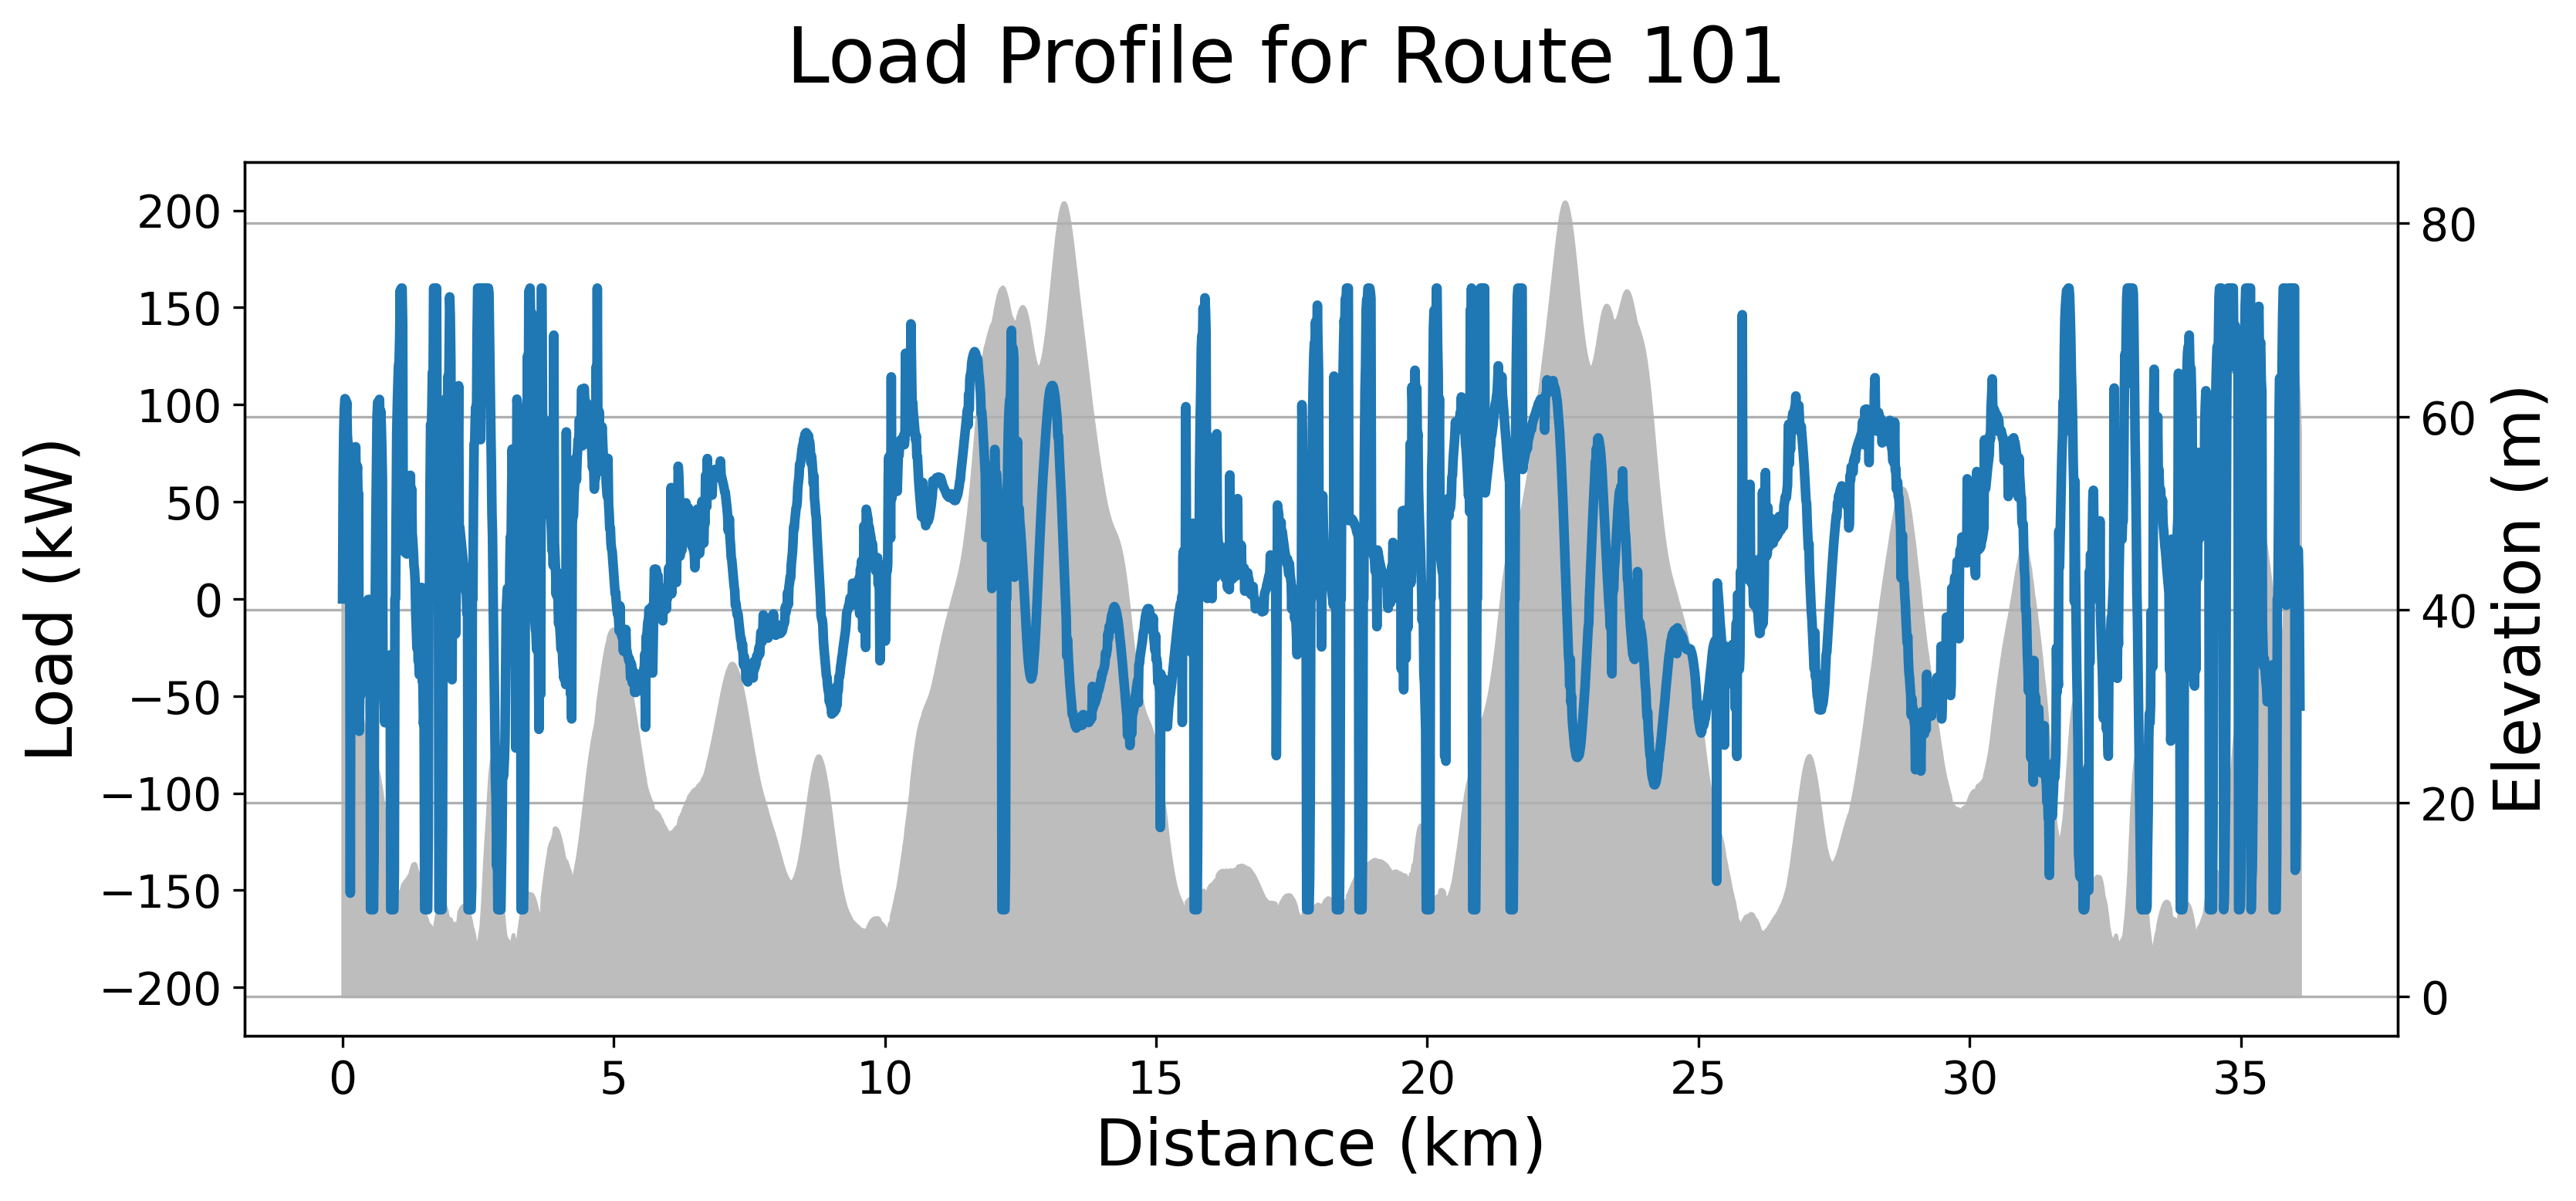

In [17]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.fill_between(rt_df['distance']/1000, rt_df['elevation'], color='#BDBDBD')
ax1 = ax.twinx()

ax1.plot(rt_df['distance']/1000, rt_df['power_output']/1000, linewidth=3)
ax1.set_ylabel('Load (kW)', fontsize=20)
ax1.set_ylim(-225, 225)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()

ax.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(route),
    fontsize=24,
    y=1,
    )


Text(0.5, 1, 'Load Profile for Route 101')

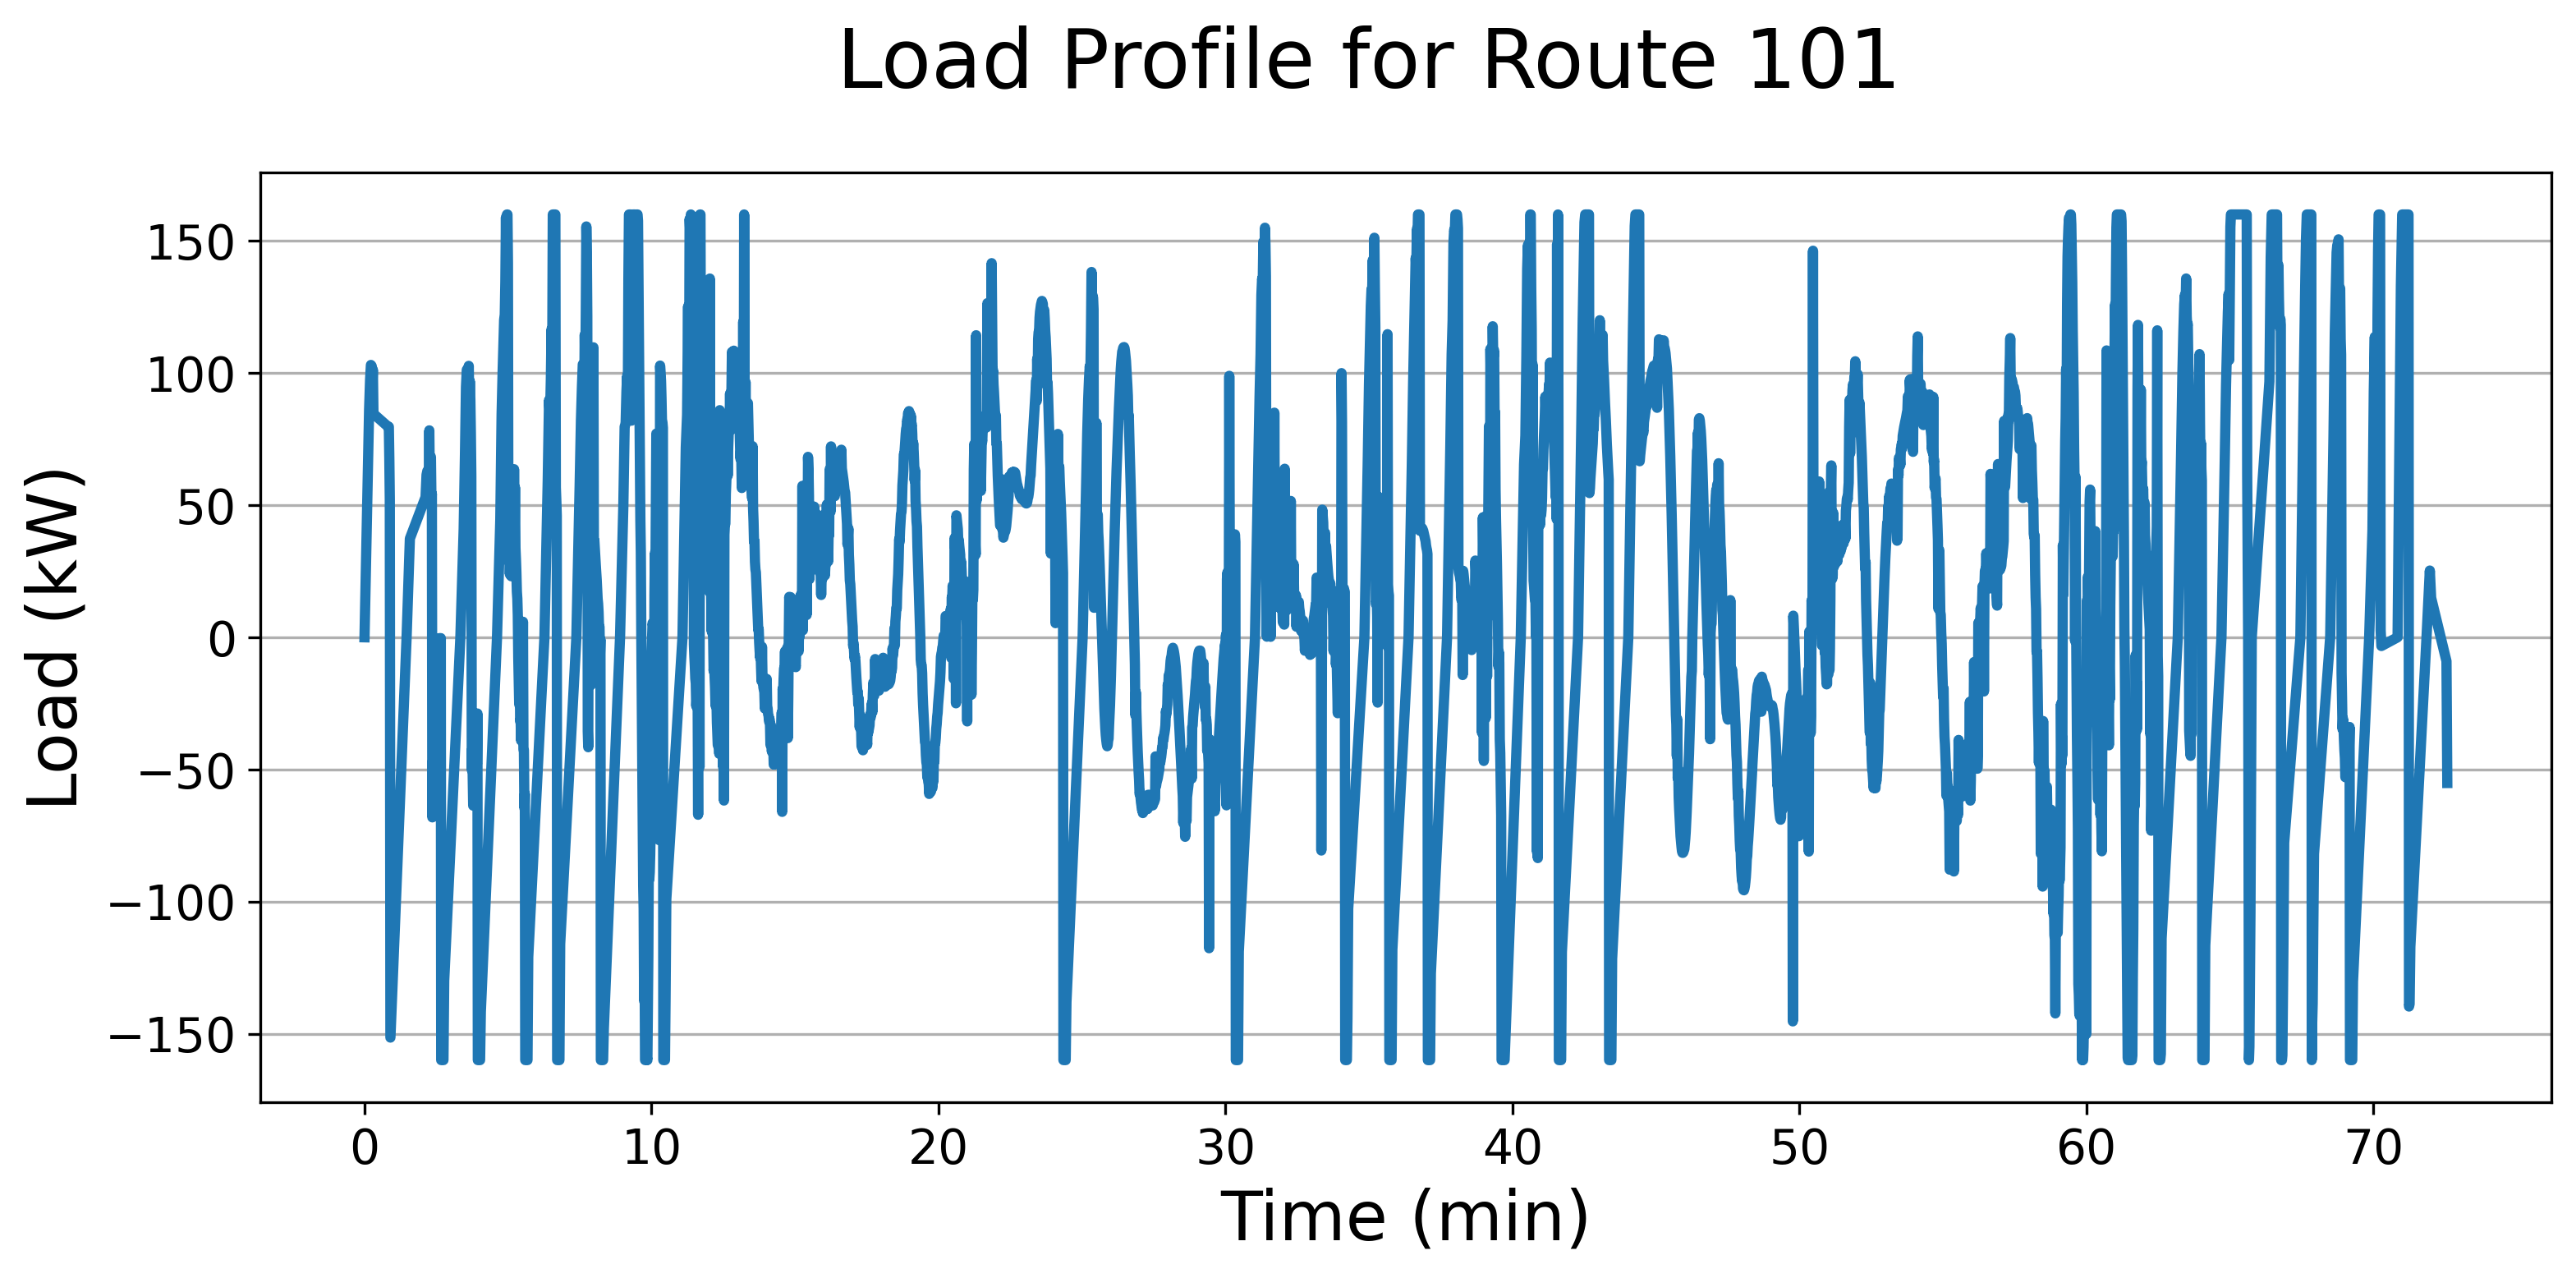

In [18]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(rt_df['total_time']/60, rt_df['power_output']/1000, linewidth=3)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

Text(0.5, 1, 'Histogram for Route 101')

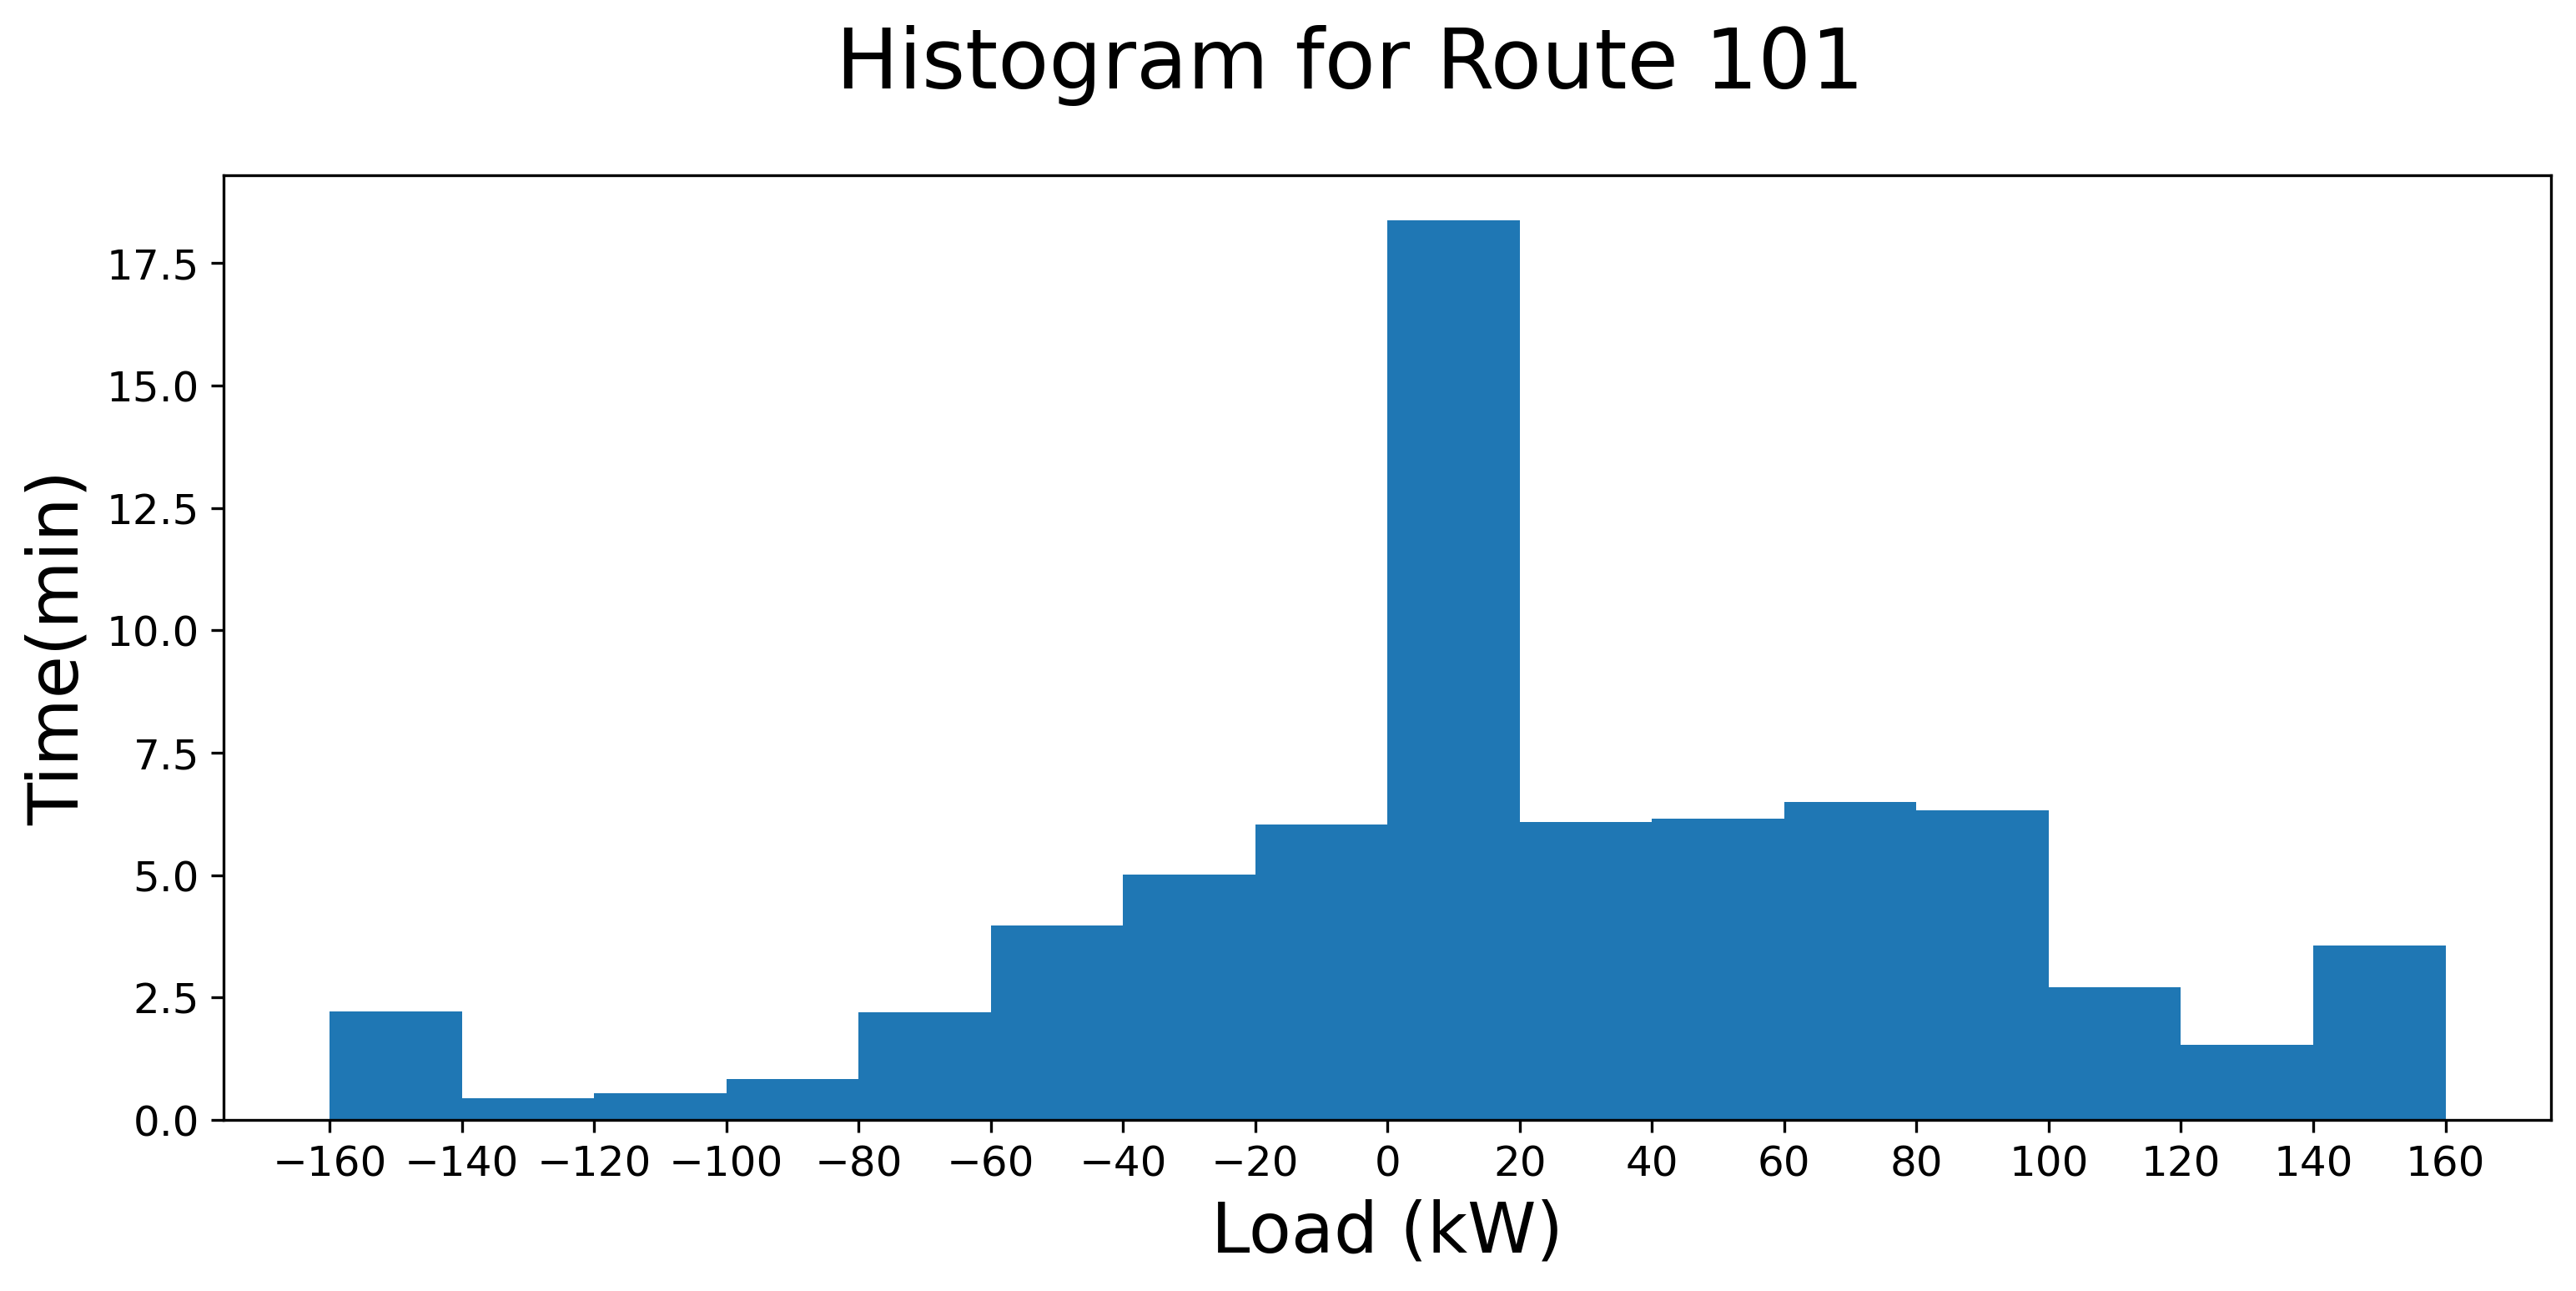

In [19]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

bins = [-160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax.hist(rt_df['power_output']/1000, bins=bins, weights=rt_df['delta_times']/60)
ax.set_ylabel('Time(min)', fontsize=20)
ax.set_xlabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_xticks(bins)

fig.suptitle(
    'Histogram for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

In [20]:
np.histogram(rt_df['power_output']/1000, bins=bins, weights=rt_df['delta_times']/60)

(array([ 2.22232573,  0.44668777,  0.55023049,  0.83830354,  2.20275201,
         3.97216047,  5.00726774,  6.04280483, 18.38240027,  6.08766209,
         6.16185357,  6.49960147,  6.32678796,  2.71694227,  1.54369395,
         3.57085138]),
 array([-160, -140, -120, -100,  -80,  -60,  -40,  -20,    0,   20,   40,
          60,   80,  100,  120,  140,  160]))

Text(0.5, 1, 'Histogram for Route 101')

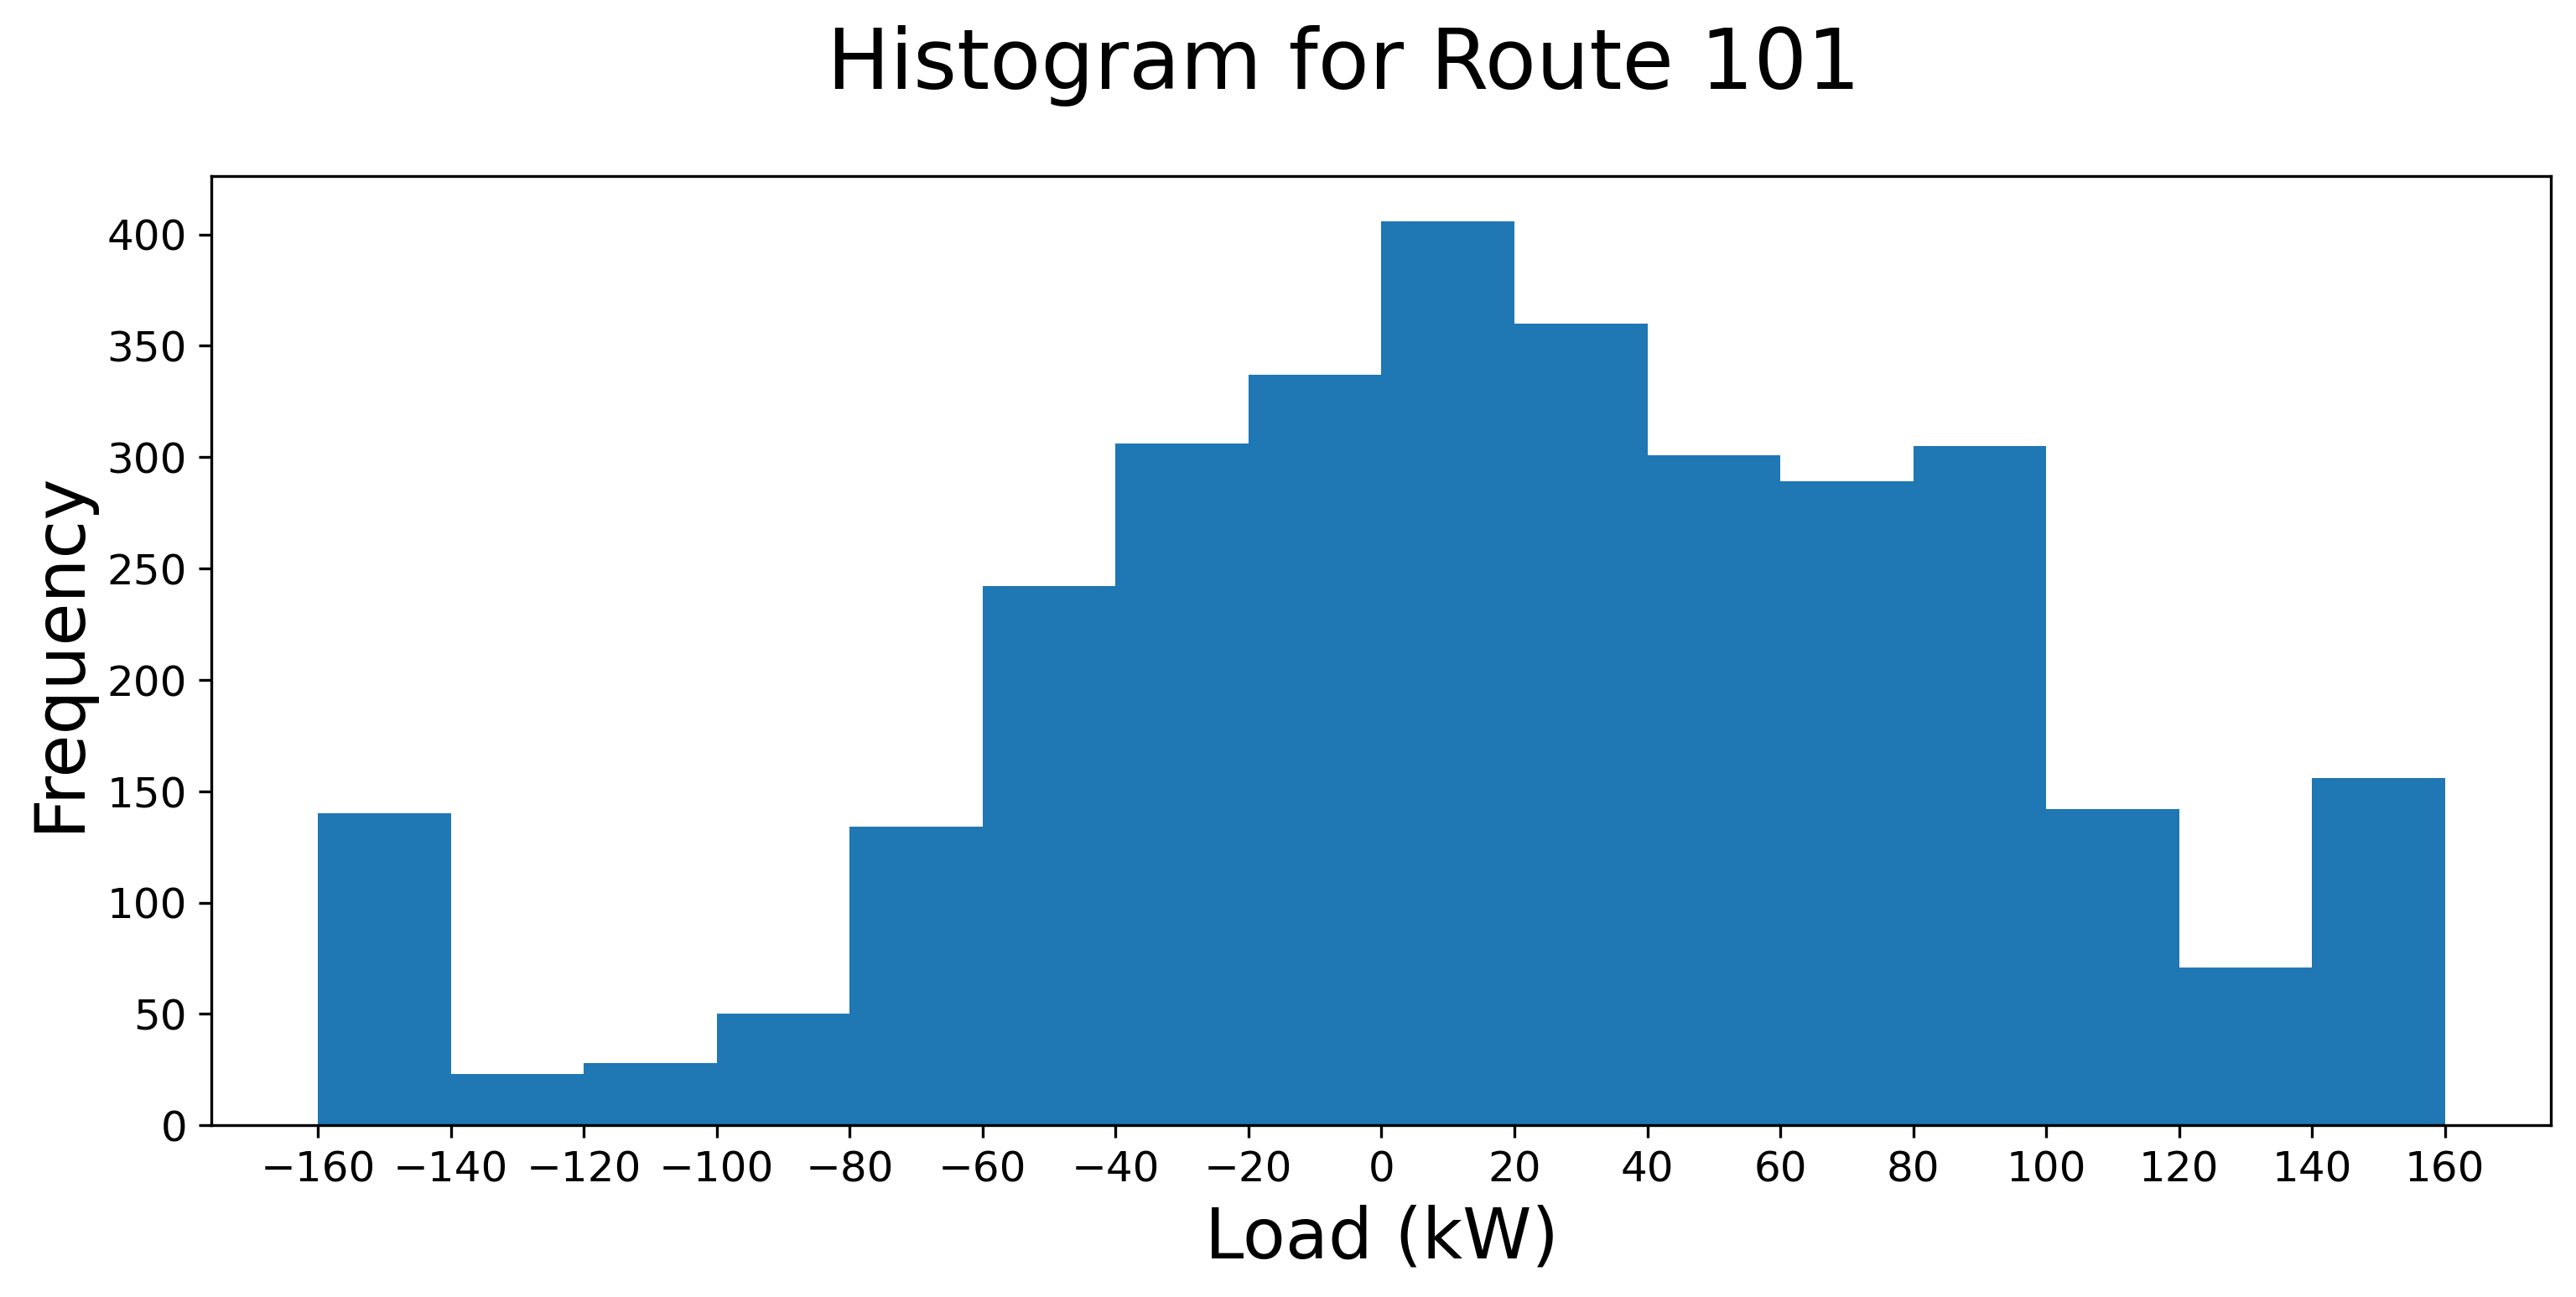

In [21]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

bins = [-160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax.hist(rt_df['power_output']/1000, bins=bins)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_xticks(bins)

fig.suptitle(
    'Histogram for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

In [22]:
ex.energy_from_route(rt_df)

25.56794264370334